In [1]:
# Este script es similar al usando para entrenar el ResNet con la diferencia de que se carga el modelo pre-entrenado
#del VGG-16
import tensorflow as tf

from tensorflow.keras.layers import Input, Dense, Flatten, Dropout
from tensorflow.keras.applications.vgg16 import VGG16 as PretrainedModel, preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from glob import glob

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys, os

In [2]:
train_path = './data/train'
valid_path = './data/test'
train_image_files = glob(train_path +'/*/*.jpg')
valid_image_files = glob(valid_path +'/*/*.jpg')

In [3]:
folders = glob(train_path + '/*')
print(folders)

['./data/train\\0', './data/train\\1', './data/train\\2', './data/train\\3', './data/train\\4', './data/train\\5']


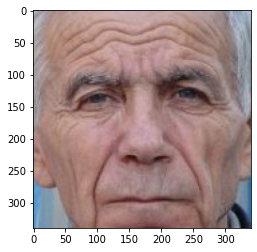

In [4]:
plt.imshow(image.load_img(np.random.choice(valid_image_files)))
plt.show()

In [5]:
IMAGE_SIZE = [200,200]
ptm = PretrainedModel(
    input_shape=IMAGE_SIZE+[3],
    weights='imagenet',
    include_top=False)

ptm.trainable = False

In [6]:

K = len(folders) 
x = Flatten()(ptm.output)

model = Model(inputs=ptm.input, outputs=x)
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 200, 200, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 200, 200, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 200, 200, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 100, 100, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 100, 100, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 100, 100, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 50, 50, 128)      

In [ ]:
gen = ImageDataGenerator(preprocessing_function=preprocess_input)

In [ ]:
batch_size = 128

train_generator = gen.flow_from_directory(
    train_path,
    target_size=IMAGE_SIZE,
    batch_size=batch_size,
    class_mode = 'sparse'
)

valid_generator = gen.flow_from_directory(
    valid_path,
    target_size=IMAGE_SIZE,
    batch_size=batch_size,
    class_mode = 'sparse'
)

In [ ]:
N_train = len(train_image_files)
N_valid = len(valid_image_files)

feat = model.predict(np.random.random([1]+IMAGE_SIZE+[3]))
D = feat.shape[1]

X_train = np.zeros((N_train,D))
Y_train = np.zeros(N_train)
X_valid = np.zeros((N_valid,D))
Y_valid = np.zeros(N_valid)

In [ ]:
i = 0
for x, y in train_generator:
    features = model.predict(x)
  
    sz = len(y)
    X_train[i:i+sz]=features
    Y_train[i:i+sz]=y

    i += sz
    if i%1280==0:
        print(i)

    if i>=N_train:
        print('breaking now')
        break

print(i)

In [ ]:
np.save('X_train_VGG.npy', X_train)
np.save('Y_train_VGG.npy', Y_train)

In [ ]:
i = 0
for x, y in valid_generator:
    features = model.predict(x)
  
    sz = len(y) 
    X_valid[i:i+sz]=features
    Y_valid[i:i+sz]=y

    i += sz
    if i%1280==0:
        print(i)

    if i>=N_valid:
        print('breaking now')
        break

print(i)

In [ ]:
np.save('X_valid_VGG.npy', X_valid)
np.save('Y_valid_VGG.npy', Y_valid)

In [7]:
X_train = np.load('X_train_VGG.npy')
Y_train = np.load('Y_train_VGG.npy')
X_valid = np.load('X_valid_VGG.npy')
Y_valid = np.load('Y_valid_VGG.npy')

In [8]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

import matplotlib.pyplot as plt
import seaborn as sns

#Definición para el calculo de metricas multi-clase
def calculo_metricas(CM, emociones):
    
    emocion = []
    TruPos = []
    FalPos = []
    FalNeg = []
    TruNeg = []
    acc = []
    prec = []
    recall = []
    f1 = []
    
    total = np.sum(CM)
    
    for i in range(len(emociones)):
       
        TP = CM[i][i]
        FP = sum(CM[:,i])-TP
        FN = sum(CM[i,:])-TP
        TN = total - TP-FN-FP
        a = (TP+TN)/(TP+TN+FN+FP)
        p = TP/(TP+FP)
        r = TP/(TP+FN)
        f = 2*(r*p)/(r+p)
        
        emocion.append(emociones[i])
        TruPos.append(TP)
        FalPos.append(FP)
        TruNeg.append(TN)
        acc.append(a)
        prec.append(p)
        recall.append(r)
        f1.append(f)
    
    metricas = pd.DataFrame()
    metricas['Emociones']=emocion
    metricas['Accuracy']=acc
    metricas['Precision']=prec
    metricas['Recall']=recall
    metricas['F1-Score']=f1
    
    return metricas

def graf_confusion_matrix(CM, emociones,emb):
    fig, ax = plt.subplots(figsize=(10,10))
    sns.heatmap(CM,annot=True,fmt='',xticklabels=emociones,yticklabels=emociones, ax=ax, cmap='Blues');
    ax.set_title('Matriz de confusión '+emb);
    ax.set_xlabel('Valores Predecidos');
    ax.set_ylabel('Valores Verdaderos');
    
def graficar_historia_entrenamiento(log, metric='accuracy'):
    fig, axes = plt.subplots(1, 2, figsize=(14,4))
    ax1, ax2 = axes
    ax1.plot(log.history['loss'], label='train')
    ax1.plot(log.history['val_loss'], label='test')
    ax1.set_xlabel('epoch'); ax1.set_ylabel('loss')
    ax2.plot(log.history[metric], label='train')
    ax2.plot(log.history['val_'+metric], label='test')
    ax2.set_xlabel('epoch'); ax2.set_ylabel(metric)
    #ax2.set_ylim((0.0, 1.0))
    for ax in axes: ax.legend()

In [39]:
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

feat = model.predict(np.random.random([1]+IMAGE_SIZE+[3]))
D = feat.shape[1]

#Callabacks
patience = 10
early_stop = EarlyStopping('val_loss',patience=patience)
reduce_lr = ReduceLROnPlateau('val_loss',factor=0.5, patience=int(patience/4), verbose=1)
callbacks = [early_stop, reduce_lr]

#Modelo de red neuronal para clasificación
#i = Input(shape=(D,))
#x = Dense(4096, activation='relu')(i)
#x = Dropout(0.2)(x)
#x = Dense(4096, activation='relu')(x)
#x = Dropout(0.2)(x)
#x = Dense(6, activation='softmax')(x)

#Modelo de red neuronal para clasificación multiclase
i = Input(shape=(D,))
x = Dense(256, activation='relu')(i)
x = Dropout(0.3)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(6, activation='softmax')(x)

emo_model = Model(i ,x)

# entrenado con metrica 'accuracy' o 'tf.keras.metrics.sparse_categorical_accuracy'
emo_model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics= 'accuracy'
)

In [40]:
r = emo_model.fit(
    X_train, Y_train,
    batch_size=128,
    epochs=20,
    callbacks = callbacks,
    validation_data=(X_valid,Y_valid)
)

Epoch 1/20
312/312 [==============================] - 20s 64ms/step - loss: 2.0243 - accuracy: 0.2415 - val_loss: 1.6052 - val_accuracy: 0.3510
Epoch 2/20
312/312 [==============================] - 17s 54ms/step - loss: 1.6662 - accuracy: 0.2870 - val_loss: 1.5433 - val_accuracy: 0.3476
Epoch 3/20
312/312 [==============================] - 16s 50ms/step - loss: 1.5983 - accuracy: 0.3273 - val_loss: 1.4895 - val_accuracy: 0.3869
Epoch 4/20
312/312 [==============================] - 16s 50ms/step - loss: 1.5277 - accuracy: 0.3547 - val_loss: 1.4693 - val_accuracy: 0.4022
Epoch 5/20
312/312 [==============================] - 16s 51ms/step - loss: 1.4886 - accuracy: 0.3700 - val_loss: 1.4506 - val_accuracy: 0.4068
Epoch 6/20
312/312 [==============================] - 17s 53ms/step - loss: 1.4605 - accuracy: 0.3821 - val_loss: 1.4484 - val_accuracy: 0.4122
Epoch 7/20
312/312 [==============================] - 17s 53ms/step - loss: 1.4313 - accuracy: 0.3958 - val_loss: 1.4476 - val_accuracy:

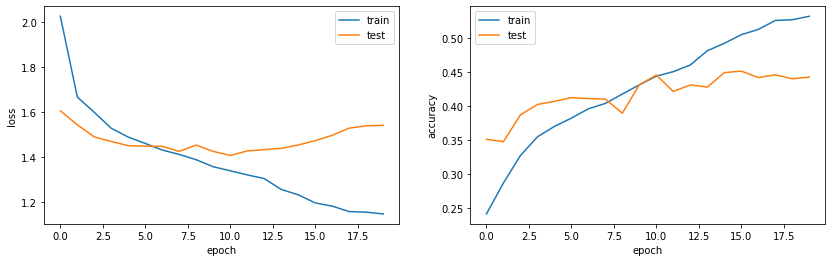

In [41]:
graficar_historia_entrenamiento(r)

In [42]:
p = emo_model.predict(X_valid)
pred = np.argmax(p, axis=1)

In [43]:
Y_valid = Y_valid.astype(int)

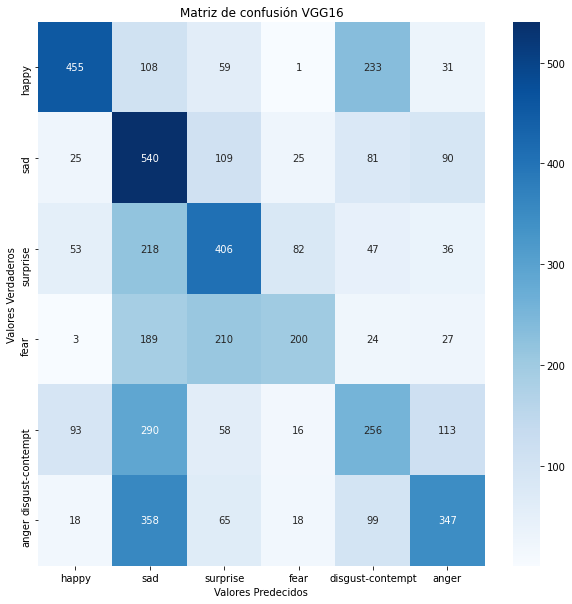

In [44]:
emo_dict = {0: 'happy', 1: 'sad', 2: 'surprise', 3: 'fear', 4: 'disgust-contempt', 5: 'anger'}
emociones_1 = list(emo_dict.values())

CM_VGG = confusion_matrix(Y_valid, pred)
graf_confusion_matrix(CM_VGG, emociones_1 ,'VGG16')

In [45]:
m1 = calculo_metricas(CM_VGG, emociones_1)
m1

,Emociones,Accuracy,Precision,Recall,F1-Score
0,happy,0.874774,0.703246,0.512965,0.593220
1,sad,0.700381,0.317087,0.620690,0.419743
2,surprise,0.811961,0.447630,0.482185,0.464265
3,fear,0.880594,0.584795,0.306279,0.402010
4,disgust-contempt,0.788481,0.345946,0.309927,0.326948
5,anger,0.828417,0.538820,0.383425,0.448031


In [46]:
m1.mean()

Accuracy     0.814101
Precision    0.489587
Recall       0.435912
F1-Score     0.442370
dtype: float64

In [ ]:
emo_model.save('top_VGG16_emotions_v1.h5')